In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-05-22 04:47:41--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: 'names.txt'

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.1s    

2024-05-22 04:47:41 (1.85 MB/s) - 'names.txt' saved [228145/228145]



Loading Corpus

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

Populating Vocabulary

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

Bulding Dataset

In [6]:
block_size = 3 # context_length

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    
    return X, Y

In [7]:
import random

In [8]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### MLP

In [9]:
# MLP Revisited
n_embd = 10 # the dimensionality of the dense char embedding vector
n_hidden = 200 # the number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)
W1 = torch.randn((n_hidden, n_embd * block_size), generator = g).T*(5/3)/((n_embd*block_size)**0.5)
# b1 = torch.randn(n_hidden, generator=g)*0.00
W2 = torch.randn((vocab_size, n_hidden), generator = g).T * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0.00

### Batch Normalisaiton

In [10]:
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

### Motivation for correct normalising constants

tensor(0.0118) tensor(0.9914)
tensor(-0.0023) tensor(3.0996)


(array([7.18774293e-06, 0.00000000e+00, 2.15632288e-05, 2.15632288e-05,
        5.75019435e-05, 5.75019435e-05, 1.15003887e-04, 1.72505830e-04,
        2.87509717e-04, 6.10958149e-04, 7.69088494e-04, 1.24347953e-03,
        2.02694351e-03, 3.37823918e-03, 5.43393366e-03, 8.27309212e-03,
        1.21329101e-02, 1.88462620e-02, 2.79387568e-02, 3.95613371e-02,
        5.45765321e-02, 7.03967543e-02, 9.21540521e-02, 1.11323763e-01,
        1.29314683e-01, 1.39348772e-01, 1.37997477e-01, 1.29357810e-01,
        1.12811625e-01, 9.33112788e-02, 7.24524488e-02, 5.40662023e-02,
        3.87131834e-02, 2.75506187e-02, 1.90331433e-02, 1.19029023e-02,
        7.97120691e-03, 5.35486849e-03, 3.07635398e-03, 2.22101257e-03,
        1.43754859e-03, 8.55341409e-04, 6.03770406e-04, 2.94697460e-04,
        1.72505830e-04, 1.36567116e-04, 6.46896864e-05, 5.03142005e-05,
        2.15632288e-05, 2.15632288e-05]),
 array([-1.80901699e+01, -1.73945412e+01, -1.66989126e+01, -1.60032839e+01,
        -1.5307655

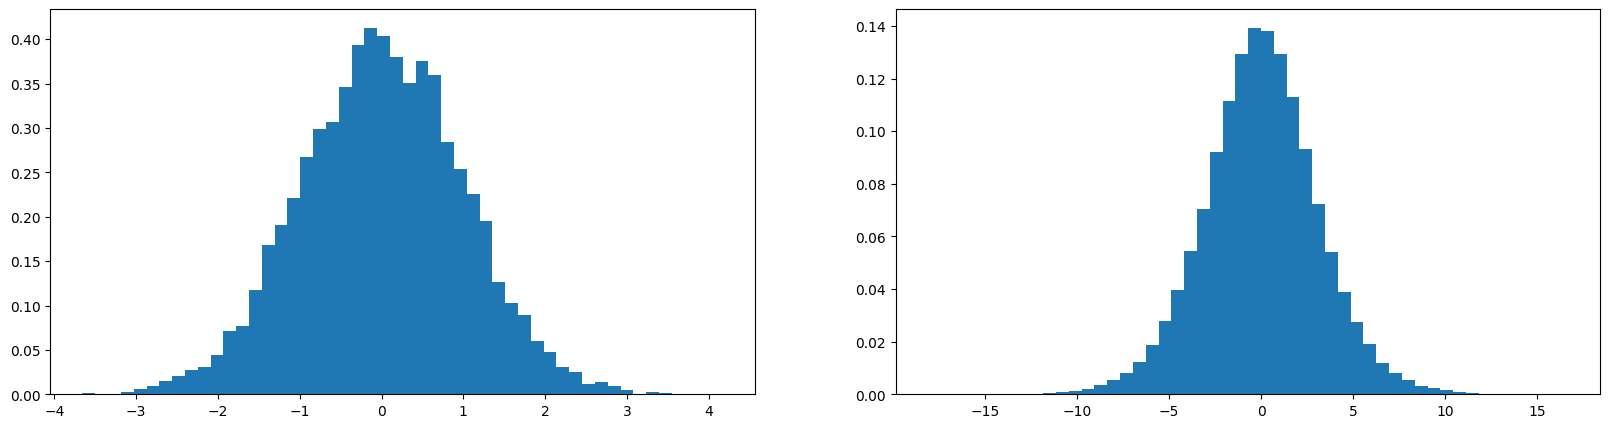

In [11]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)

Mean remains the same, but std div has expanded, but we dont want that \
so we must scale w, correctly suchthat it preserves the gaussian \
Mathematically comes out to be divided by the squareroot of fan in, that is shape[0]
```
W1 = torch.randn((n_hidden, n_embd * block_size), generator = g).T*(5/3)/((n_embd*block_size)**0.5)
```

Most people use the inbuild `kaiming_normalisation` 

and we also need a gain included in this std normalisation as tanh is a contractive activation

### Preparing for grad

In [12]:
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [13]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # Normalisation
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2944
  10000/ 200000: 2.1204
  20000/ 200000: 2.6738
  30000/ 200000: 1.9978
  40000/ 200000: 2.2211
  50000/ 200000: 1.8527
  60000/ 200000: 2.0737
  70000/ 200000: 2.2758
  80000/ 200000: 2.3699
  90000/ 200000: 2.1287
 100000/ 200000: 2.2205
 110000/ 200000: 2.4661
 120000/ 200000: 1.7136
 130000/ 200000: 2.0199
 140000/ 200000: 2.1848
 150000/ 200000: 1.9880
 160000/ 200000: 2.0510
 170000/ 200000: 2.4521
 180000/ 200000: 2.1227
 190000/ 200000: 2.1528


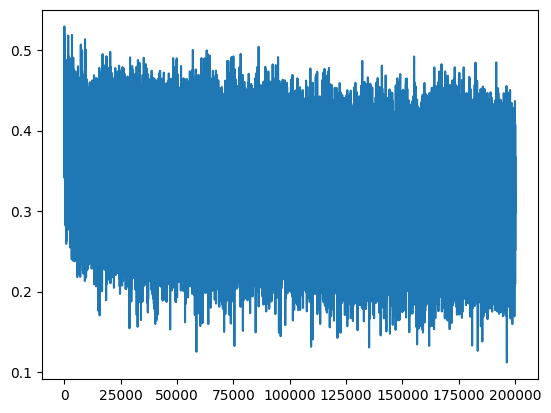

In [14]:
plt.plot(lossi)

In [15]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [16]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train' : {Xtr, Ytr},
        'val' : {Xdev, Ydev},
        'test' : {Xte, Yte}
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    hpreact =  bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0679590702056885
val 2.1088221073150635


In [17]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0]*block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1) # + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break 
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out)) # decodeand print the generated word

briah.
myazlieenmilynn.
sabellascengrlot.
shelydanliths.
girenleyegssandalissathi.
shqayce.
shub.
roxhiriestin.
joxcelshnnicolfsubfatvenshyldur.
els.
gianghstlyanshinshalyanshupubialventen.
try.
bronaoellafrdin.
brookobh.
gicibroretty.
brhun.
bluisaqiifelvondwriah.
xtharshzthed.
silvissif.
fadvissivliviennakelandiyaxabiguhmi.
